This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


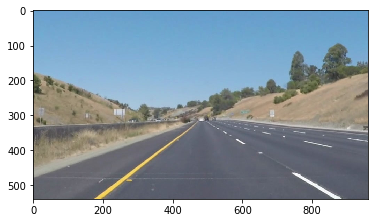

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
directory = 'test_images/'
os.listdir(directory)
#image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('test_images/solidYellowCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

In [2]:
#image = cv2.imread('test_images/whiteCarLaneSwitch.jpg')
#cv2.imwrite('test_images_results/Test_gray.jpg', image)

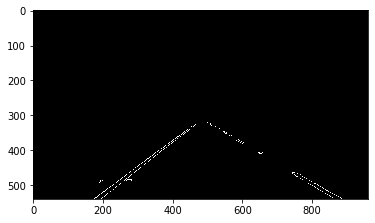

In [23]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
plt.imshow(gray, cmap='gray')
# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 150
masked_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(masked_edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(490, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(masked_edges, mask)

# Display the image
plt.imshow(masked_edges, cmap='Greys_r')

In [4]:
kernel = np.ones((5,5), np.uint8) 
  
# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
#img_dila = cv2.dilate(masked_edges, kernel, iterations=1) 
#img_erosion = cv2.erode(img_dila, kernel, iterations=1) 
#plt.imshow(img_erosion, cmap='Greys_r')

#cv2.fillPoly(gray, masked_edges, (255,0,0))

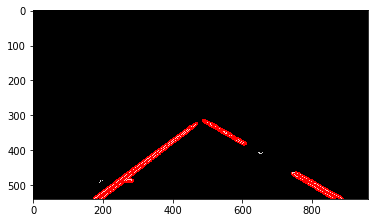

In [24]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2
theta = 1*np.pi/180
threshold = 15
min_line_length = 20
max_line_gap = 25
line_image = np.copy(image)*0 #creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)

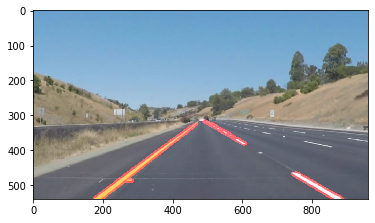

In [4]:
ResultImage = cv2.addWeighted(image, 1, line_image, 1, 0) 
plt.imshow(ResultImage)
#plt.savefig('test_images_results/ResultImage.jpg')

In [7]:
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
image = cv2.imread('test_images/whiteCarLaneSwitch.jpg')
ResultImage = cv2.addWeighted(image, 1, line_image, 1, 0) 
cv2.imshow('image',ResultImage)
cv2.waitKey(0)
cv2.imwrite('test_images_results/Test_gray.jpg', ResultImage)

True

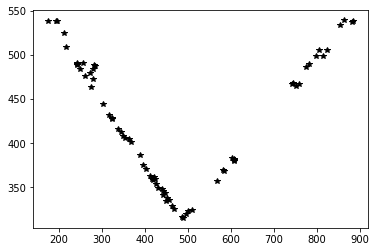

In [8]:
#a = np.array([1, 2, 3, 4])
i = 0
#a = [0,0] * len(lines)
a = [[0] * len(lines), [0] * len(lines)]
for pltline in lines:
    for x1,y1,x2,y2 in pltline:
        plt.plot([x1, x2], [y1, y2],'*k')
        a[0][i] = ((y2-y1)/(x2-x1))
        a[1][i] = ((y2-y1)**2 + (x2-x1)**2)**(1/2)
        i = i + 1
#plt.show()
#plt.plot(a[0],'*')
#plt.show()
#plt.plot(a[1],'-')

In [61]:
from scipy.optimize import curve_fit
def NegLineFit(img, line):
    xCurveDataNeg = np.array([])
    yCurveDataNeg = np.array([])
    for LinesNeg in line:
        for x1,y1,x2,y2 in LinesNeg:
            if ((y2-y1)/(x2-x1)) < 0:
                #plt.plot([x1, x2], [y1, y2],'*k')
                xCurveDataNeg = np.concatenate((xCurveDataNeg,np.array([x1, x2])))
                yCurveDataNeg = np.concatenate((yCurveDataNeg,np.array([y1, y2])))
    #plt.plot(xCurveDataNeg,yCurveDataNeg,'*k')

    def CurveFitFunc(x, a, b):
        return a * x + b
    def CurveFitFuncInv(y, a, b):
        return (y-b) / a

    popt, pcov = curve_fit(CurveFitFunc, xCurveDataNeg, yCurveDataNeg)
    #plt.plot(xCurveDataNeg, CurveFitFunc(xCurveDataNeg, *popt), 'r-',)

    yMax = img.shape[0]
    xStartNeg = CurveFitFuncInv(yMax, *popt)
    xEndNeg = CurveFitFuncInv(320, *popt)
    yCurveNeg = CurveFitFunc(np.array([xStartNeg, xEndNeg]), *popt) 
    LineNeg = [xStartNeg,max(yCurveNeg),xEndNeg,min(yCurveNeg)]
    LineNeg = [int(i) for i in LineNeg]
    return LineNeg

In [70]:
def PosLineFit(img, line):
    xCurveDataPos = np.array([])
    yCurveDataPos = np.array([])
    for LinesPos in line:
        for x1,y1,x2,y2 in LinesPos:
            if ((y2-y1)/(x2-x1)) > 0:
                #plt.plot([x1, x2], [y1, y2],'*k')
                xCurveDataPos = np.concatenate((xCurveDataPos,np.array([x1, x2])))
                yCurveDataPos = np.concatenate((yCurveDataPos,np.array([y1, y2])))
    #plt.plot(xCurveDataPos,yCurveDataPos,'*k')

    def CurveFitFunc(x, a, b):
        return a * x + b
    def CurveFitFuncInv(y, a, b):
        return (y-b) / a

    popt, pcov = curve_fit(CurveFitFunc, xCurveDataPos, yCurveDataPos)
    #plt.plot(xCurveDataPos, CurveFitFunc(xCurveDataPos, *popt), 'r-',)

    yMax = img.shape[0]
    xStartPos = CurveFitFuncInv(yMax, *popt)
    xEndPos = CurveFitFuncInv(320, *popt)
    yCurvePos = CurveFitFunc(np.array([xStartPos, xEndPos]), *popt) 
    LinePos = [xStartPos,max(yCurvePos),xEndPos,min(yCurvePos)]
    LinePos = [int(i) for i in LinePos]
    return LinePos

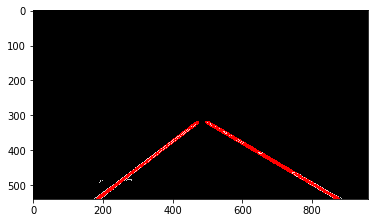

In [72]:
lineImg = np.copy(image)*0
LinesFit = np.array([[NegLineFit(lineImg, lines)],[PosLineFit(lineImg, lines)]])
for line in LinesFit:
    for x1,y1,x2,y2 in line:
        cv2.line(lineImg,(x1,y1),(x2,y2),(255,0,0),10)
plt.imshow(lineImg)
combox = cv2.addWeighted(color_edges, 0.8, lineImg, 1, 0) 
plt.imshow(combox)

In [ ]:
cv2.line(lineImg,(LinesImeX[0],LinesImeX[2]),(LinesImeX[1],LinesImeX[3]),(255,0,0),10)
plt.imshow(lineImg)
combox = cv2.addWeighted(color_edges, 0.8, line_imagex, 1, 0) 
plt.imshow(combox)

[[194,
  424,
  176,
  317,
  303,
  417,
  195,
  257,
  250,
  324,
  426,
  456,
  442,
  468,
  349,
  397,
  419,
  453,
  243,
  280,
  242,
  284,
  412,
  443,
  216,
  276,
  422,
  450,
  339,
  369,
  213,
  272,
  403,
  441,
  354,
  390,
  260,
  280,
  324,
  344,
  431,
  463,
  242,
  282,
  364,
  447],
 [538,
  359,
  538,
  432,
  444,
  359,
  538,
  491,
  484,
  427,
  353,
  335,
  341,
  325,
  408,
  375,
  358,
  338,
  488,
  484,
  489,
  487,
  363,
  346,
  509,
  463,
  361,
  334,
  416,
  401,
  524,
  479,
  370,
  348,
  405,
  386,
  476,
  472,
  428,
  412,
  349,
  329,
  490,
  488,
  404,
  343]]

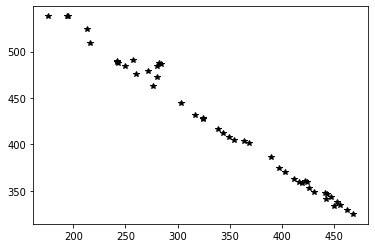

In [29]:
i = 0
CurveData = [[0] * len(lines), [0] * len(lines)]
CurveData = [[0] * 46, [0] * 46]
for pltline in lines:
    for x1,y1,x2,y2 in pltline:
        if ((y2-y1)/(x2-x1)) < 0:
            plt.plot([x1, x2], [y1, y2],'*k')
            CurveData[0][i] = x1
            CurveData[1][i] = y1
            i = i + 1
            CurveData[0][i] = x2
            CurveData[1][i] = y2
            i = i + 1
#CurveData

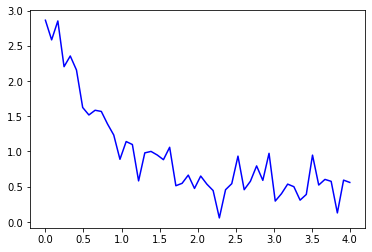

In [76]:
>>> xdata = np.linspace(0, 4, 50)
>>> y = func(xdata, 2.5, 1.3, 0.5)
>>> np.random.seed(1729)
>>> y_noise = 0.2 * np.random.normal(size=xdata.size)
>>> ydata = y + y_noise
>>> plt.plot(xdata, ydata, 'b-', label='data')

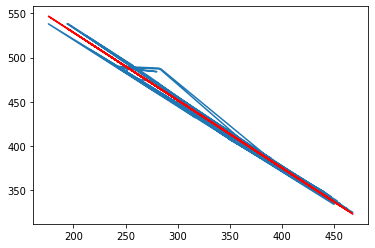

In [109]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b
def invfunc(y, a, b):
    return (y-b) / a
xdata = CurveData[0]
ydata = CurveData[1]
xdata = np.array(xdata)
ydata = np.array(ydata)
plt.plot(xdata, ydata)
popt, pcov = curve_fit(func, xdata, ydata)
popt
xdata = np.asarray(xdata)
plt.plot(xdata, func(xdata, *popt), 'r-',)

yMax = image.shape[0]
xStart = invfunc(yMax, *popt)
xEnd = invfunc(320, *popt)
yNegOutput = func(np.array([xStart, xEnd]), *popt)

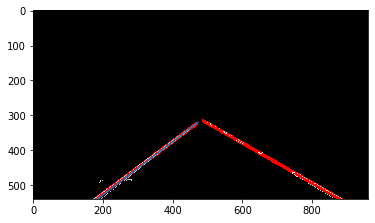

In [114]:
xStart
xEnd
yNegOutput
plt.plot(np.array([xStart, xEnd]),yNegOutput)
lineImg = np.copy(image)*0 #creating a blank to draw lines on
LinesImeX = [xStart,xEnd,max(yNegOutput),min(yNegOutput)]
LinesImeX = [int(i) for i in LinesNewx]
cv2.line(lineImg,(LinesImeX[0],LinesImeX[2]),(LinesImeX[1],LinesImeX[3]),(255,0,0),10)
plt.imshow(lineImg)
combox = cv2.addWeighted(color_edges, 0.8, line_imagex, 1, 0) 
plt.imshow(combox)

In [88]:
aPos = [i for i in a[0] if i > 0]
aPosLen = [a[1][a[0].index(i)] for i in a[0] if i > 0]
aNeg = [i for i in a[0] if i <= 0]
aNegLen = [a[1][a[0].index(i)] for i in a[0] if i <= 0]
aPosAve = sum(aPos)/len(aPos)
aNegAve = sum(aNeg)/len(aNeg)
aAveAbs = sum(list(map(abs, a[0])))/len(a[0])
print(aAveAbs)
print(aNegAve)
print(aPosAve)
aX = [i for i in a[0] if abs(abs(i)-aAveAbs)<0.25]
print(aX)
print("lengths: ",len(a[0]) , len(aX))
aY = [i for i in a[0] if abs(abs(i)-aAveAbs)<0.25]

0.5815419754086022
-0.5873715675345816
0.5712280816472541
[-0.7782608695652173, -0.75177304964539, -0.7456140350877193, 0.6, 0.5538461538461539, 0.5918367346938775, 0.5535714285714286, -0.7580645161290323, -0.7702702702702703, -0.6, 0.5726495726495726, -0.6153846153846154, 0.6153846153846154, 0.5409836065573771, -0.6875, -0.5882352941176471, -0.5483870967741935, -0.7666666666666667, 0.5757575757575758, -0.5, 0.5609756097560976, 0.543859649122807, 0.5454545454545454, 0.5316455696202531, 0.64, -0.7627118644067796, -0.5789473684210527, -0.5277777777777778, -0.8, -0.625, -0.7349397590361446]
lengths:  36 31


In [89]:
aPosX = [i for i in aPos if abs(abs(i)-aAveAbs)<0.1]
print("lengths: ",len(aPos) , len(aPosX))
#aNegX = [i for i in aNeg if abs(abs(i)-aAveAbs)<1]
aNegX = [i for i in aNeg if i<aNegAve]
print("lengths: ",len(aNeg) , len(aNegX))

lengths:  13 13
lengths:  23 15


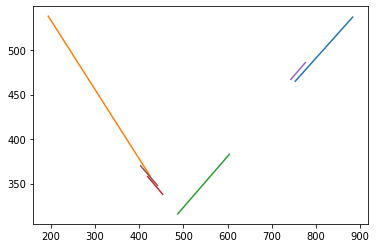

In [90]:
max(aPosLen)
MaxLenIndPos = a[1].index(max(aPosLen))
#MaxLenSlope = a[0][MaxLenInd]
max(aNegLen)
MaxLenIndNeg = a[1].index(max(aNegLen))
#MaxLenSlope = a[0][MaxLenInd]
for x1,y1,x2,y2 in lines[MaxLenIndPos]: plt.plot([x1, x2], [y1, y2])
for x1,y1,x2,y2 in lines[MaxLenIndNeg]: plt.plot([x1, x2], [y1, y2])
#a[0][a[1].index((max(aPosLen)))]
aX = [i for i in a[0] if abs(abs(i)-aAveAbs)<0.01]
#lines[a.index(aX[0])]
#plt.plot(lines[a.index(aX[0])])
#plt.plot([743, 776], [467, 486])
len(aX)
#for pltInd in len(aX):
#    for x1,y1,x2,y2 in lines[a.index(pltInd)]:
#        plt.plot([x1, x2], [y1, y2])
for pltInd in aX:
    for x1,y1,x2,y2 in lines[a[0].index(pltInd)]:
        plt.plot([x1, x2], [y1, y2])

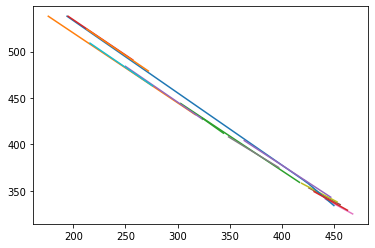

In [91]:
for pltInd in aNegX:
    for x1,y1,x2,y2 in lines[a[0].index(pltInd)]:
        plt.plot([x1, x2], [y1, y2])

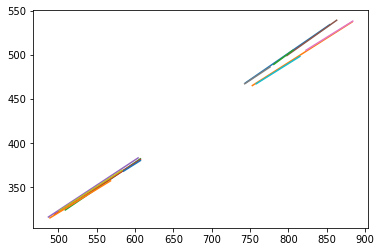

In [92]:
for pltInd in aPos:
    for x1,y1,x2,y2 in lines[a[0].index(pltInd)]:
        plt.plot([x1, x2], [y1, y2])

314.93333333333334
384.3333333333333
438.46666666666664
386.73333333333335
-0.7454370797310275
-0.7782608695652173


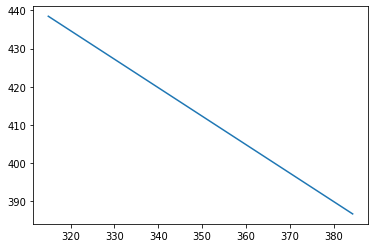

In [93]:
i = 0
xyNeg = [[0] * len(aNegX), [0] * len(aNegX), [0] * len(aNegX), [0] * len(aNegX)]
for pltline in lines:
    for x1,y1,x2,y2 in pltline:
        SlopeTmp = ((y2-y1)/(x2-x1))
        #if SlopeTmp < 0 and abs(abs(SlopeTmp)-aAveAbs)<0.25:
        if SlopeTmp < 0 and SlopeTmp<aNegAve:
            xyNeg[0][i] = x1
            xyNeg[1][i] = x2
            xyNeg[2][i] = y1
            xyNeg[3][i] = y2
            i = i + 1
#plt.plot(xy[0])
x1Neg = sum(xyNeg[0])/len(xyNeg[0])
x2Neg = sum(xyNeg[1])/len(xyNeg[0])
y1Neg = sum(xyNeg[2])/len(xyNeg[0])
y2Neg = sum(xyNeg[3])/len(xyNeg[0])
print(x1Neg)
print(x2Neg)
print(y1Neg)
print(y2Neg)
plt.plot([x1Neg, x2Neg],[y1Neg, y2Neg])
#plt.plot([min(xyNeg[0]),max(xyNeg[1])],[max(xyNeg[3]),min(xyNeg[2])])
print((y2Neg-y1Neg)/(x2Neg-x1Neg))
print(a[0][0])

In [94]:
mslope = sum(aNeg)/len(aNeg)
mslope2 = -0.77

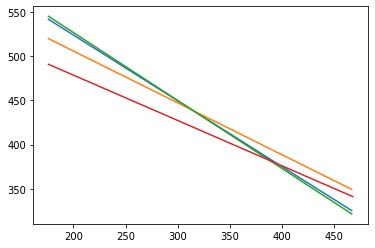

In [95]:
inpsNeg = list(range(min(xyNeg[0]), max(xyNeg[1])))
idx = 0
youtNeg = [0]*len(inpsNeg)
youtNegf = [0]*len(inpsNeg)
youtNegff = [0]*len(inpsNeg)
for i in inpsNeg:
    youtNeg[idx] = ((y2Neg-y1Neg)/(x2Neg-x1Neg))*(i-x1Neg) + y1Neg
    youtNegf[idx] = mslope*(i-x1Neg) + y1Neg
    youtNegff[idx] = mslope2*(i-x1Neg) + y1Neg
    idx = idx + 1
plt.plot(inpsNeg,youtNeg)
plt.plot(inpsNeg,youtNegf)
plt.plot(inpsNeg,youtNegff)
plt.plot([min(xyNeg[0]),max(xyNeg[1])],[max(xyNeg[3]),min(xyNeg[2])])

0.5691220988900102
-0.5642317380352645


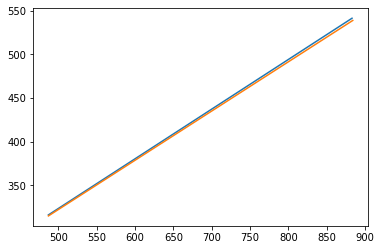

In [96]:
i = 0
xyPos = [[0] * len(aPosX), [0] * len(aPosX), [0] * len(aPosX), [0] * len(aPosX)]
for pltline in lines:
    for x1,y1,x2,y2 in pltline:
        SlopeTmp = ((y2-y1)/(x2-x1))
        if SlopeTmp > 0 and abs(abs(SlopeTmp)-aAveAbs)<0.25:
            xyPos[0][i] = x1
            xyPos[1][i] = x2
            xyPos[2][i] = y1
            xyPos[3][i] = y2
            i = i + 1
#plt.plot(xy[0])
x1Pos = sum(xyPos[0])/len(xyPos[0])
x2Pos = sum(xyPos[1])/len(xyPos[0])
y1Pos = sum(xyPos[2])/len(xyPos[0])
y2Pos = sum(xyPos[3])/len(xyPos[0])

inpsPos = list(range(min(xyPos[0]), max(xyPos[1])))
idx = 0
youtPos = [0]*len(inpsPos)
for i in inpsPos:
    youtPos[idx] = ((y2Pos-y1Pos)/(x2Pos-x1Pos))*(i-x1Pos) + y1Pos
    idx = idx + 1
plt.plot(inpsPos,youtPos)
plt.plot([min(xyPos[0]),max(xyPos[1])],[min(xyPos[2]),max(xyPos[3])])
print((y2Pos-y1Pos)/(x2Pos-x1Pos))
asf = (max(xyPos[3])-min(xyPos[2]))/(min(xyPos[0])-max(xyPos[1]))
print(asf)

In [97]:
linesN = lines[[0]]
linesN[0] = [min(inpsNeg),max(inpsNeg),max(youtNeg),min(youtNeg)]
print(linesN[0])
print(lines[0])

[[176 467 542 325]]
[[194 538 424 359]]


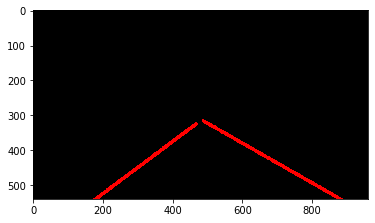

In [98]:
line_imagex = np.copy(image)*0 #creating a blank to draw lines on
LinesNewx = [min(inpsNeg),max(inpsNeg),max(youtNeg),min(youtNeg)]
LinesNewx = [int(i) for i in LinesNewx]
cv2.line(line_imagex,(LinesNewx[0],LinesNewx[2]),(LinesNewx[1],LinesNewx[3]),(255,0,0),10)
LinesNewx = [min(inpsPos),max(inpsPos),min(youtPos),max(youtPos)]
LinesNewx = [int(i) for i in LinesNewx]
cv2.line(line_imagex,(LinesNewx[0],LinesNewx[2]),(LinesNewx[1],LinesNewx[3]),(255,0,0),10)
plt.imshow(line_imagex)

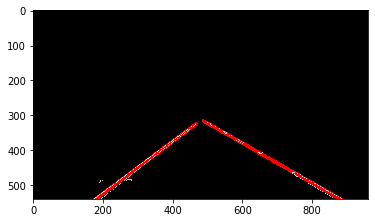

In [99]:
combox = cv2.addWeighted(color_edges, 0.8, line_imagex, 1, 0) 
plt.imshow(combox)

#imagex = cv2.imread('test_images/whiteCarLaneSwitch.jpg')
#ResultImagex = cv2.addWeighted(imagex, 1, line_imagex, 1, 0) 
#cv2.imshow('image',ResultImagex)
#cv2.waitKey(0)

In [25]:
LinesNewx = [min(inpsNeg),max(inpsNeg),max(youtNeg),min(youtNeg)]
LinesNewx = [int(i) for i in LinesNewx]
LinesNewx

[176, 467, 528, 337]

In [374]:
#plt.plot([194, 424], [538, 359])
#plt.plot([176, 317], [538, 432])

In [168]:
#for file in os.listdir('test_images/'): image = mpimg.imread(directory+file)
#plt.imshow(image)

In [ ]:
#pip install opencv-python
#pip install moviepy